In [1]:
import pandas as pd
import numpy as np
import os
from pcntoolkit.dataio.fileio import load as ptkload
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import matplotlib as mpl
from pathlib  import Path
from pcntoolkit.dataio.fileio import save_nifti, load_nifti
from pcntoolkit.dataio.fileio import save as ptksave

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl", 9)


# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'
proc_dir = os.path.join(root_dir,'Z_stat/')
data_dir = os.path.join(proc_dir,'data/')
w_dir = os.path.join(proc_dir,'vox/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#SVM classification Contingency Aware vs Unaware

#%%LOAD IN DATA AND MASK BY AVAILABLE PARTICIPANTS
# Load in the Z_est files
Z_est_control_test = ptkload(os.path.join(w_dir,'Z_estimate.pkl'), mask=mask_nii)
Z_est_clinical = ptkload(os.path.join(w_dir,'Z_predcl.pkl'), mask=mask_nii)
Full_sample_deviations = np.append(Z_est_control_test,Z_est_clinical, axis = 0)

#Load in the contingency awareness data
Contingency_Aware = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/all_test_validation.csv', usecols = ['Contigency_aware', 'Principal_diagnosis_current'])
Contingency_Aware['Principal_diagnosis_current'] = Contingency_Aware['Principal_diagnosis_current'].replace({np.nan: 'NA', 'nan': 'NA'})


#print(len(Z_est_control_test))
#print(len(Z_est_clinical))
#print(len(Full_sample_deviations))
#print(len(Contingency_Aware))



#REPLACE ALL NOT AVAILABLE with NA
Contingency_Aware.replace(to_replace='not assessed/not available', value='NA', regex=True, inplace=True)
Contingency_Aware.replace(to_replace='not available', value='NA', regex=True, inplace=True)
Contingency_Aware.replace(to_replace='not applicable', value='NA', regex=True, inplace=True)


#Mask by participants for whom CA data is available
mask_CA = Contingency_Aware['Contigency_aware'].notna() #remove NAs
mask_exclude_diagnosis = ~Contingency_Aware['Principal_diagnosis_current'].isin(['others', 'schizophrenia']) #and remove others and schizophrenia
combined_mask = mask_CA & mask_exclude_diagnosis


CA_sample_yes_no = Contingency_Aware['Contigency_aware'][combined_mask].to_numpy()
CA_sample_deviations = Full_sample_deviations[combined_mask]

print('Contingency Awareness data is available for '+str(len(CA_sample_deviations)) +' participants')

Contingency Awareness data is available for 703 participants


In [3]:
print(CA_sample_yes_no)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

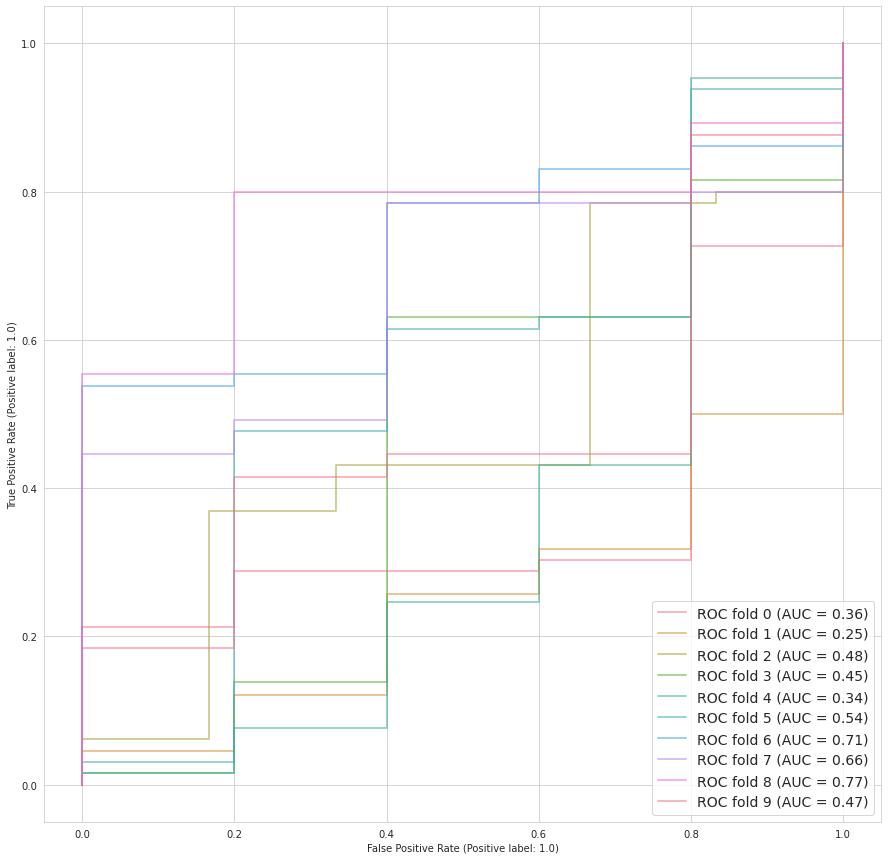

In [4]:
#Define parameters
X1 = CA_sample_deviations #Deviations
y = CA_sample_yes_no.ravel()
n_samples, n_features = X1.shape
random_state = np.random.RandomState(0)

#RUN CLASSIFICATION with 10-cross fold stratificiation
cv = StratifiedKFold(n_splits=10)

classifier_z = svm.SVC(kernel="linear", probability=True, random_state=random_state, class_weight='balanced')

tprs_z = []
aucs_z = []
aucs_z_perms = []
mean_auc_z_perms = []
coefs = []
mean_fpr_z = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,15))
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':16,'ytick.labelsize':16,'legend.fontsize':14,'legend.title_fontsize':16}
plt.rcParams.update(parameters)
    
for i, (train, test) in enumerate(cv.split(X1, y)):
    classifier_z.fit(X1[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier_z,
        X1[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.5,
        lw=2,
        ax=ax,
    )
    interp_tpr_z = np.interp(mean_fpr_z, viz.fpr, viz.tpr)
    interp_tpr_z[0] = 0.0
    tprs_z.append(interp_tpr_z)
    aucs_z.append(viz.roc_auc)
    coefs.append(classifier_z.coef_)

mean_tpr_z = np.mean(tprs_z, axis=0)
mean_tpr_z[-1] = 1.0
mean_auc_z = auc(mean_fpr_z, mean_tpr_z)
std_auc_z = np.std(aucs_z)
aucs_z_perms.append(aucs_z)
mean_auc_z_perms.append(mean_auc_z)

np.save((os.path.join(w_dir +'Validation/Contingency_Awareness_mean_auc.npy')), mean_auc_z_perms)
np.save((os.path.join(w_dir +'Validation/Contingency_Awareness_std_auc.npy')), std_auc_z)
np.save((os.path.join(w_dir +'Validation/Contingency_Awareness_coefs.npy')), coefs)


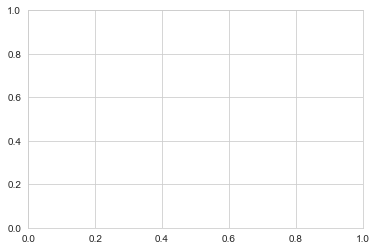

In [5]:
#Plot means
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.9)

ax.plot(mean_fpr_z, mean_tpr_z, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_z, std_auc_z),
        lw=3, alpha=.9)

std_tpr_z = np.std(tprs_z, axis=0)
tprs_upper_z = np.minimum(mean_tpr_z + std_tpr_z, 1)
tprs_lower_z = np.maximum(mean_tpr_z - std_tpr_z, 0)
ax.fill_between(mean_fpr_z, tprs_lower_z, tprs_upper_z, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.rc('axes', labelsize=14) #fontsize of the x and y labels
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title('Receiver operating characteristic Contingency Aware vs. Unaware (functional deviations)', fontweight="bold", size=20, font = fpath)
ax.legend(loc="lower right")
plt.yticks(font = fpath)
plt.xticks(font = fpath)
plt.show()

fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/CA_SVM_balanced.png', dpi=300)

In [6]:
#save voxels level coefficients
coefs_mean =  np.mean(coefs, axis=0) #save as nifti
out_filename = (w_dir +'Validation/Contingency_Awareness_meanCoefs.nii.gz')
ptksave(coefs_mean, out_filename, example=ex_nii, mask=mask_nii)


[ 7.25462304 92.74537696]


/scratch/hansav/52784095.dccn-l029.dccn.nl/ipykernel_25035/1628462920.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' '])


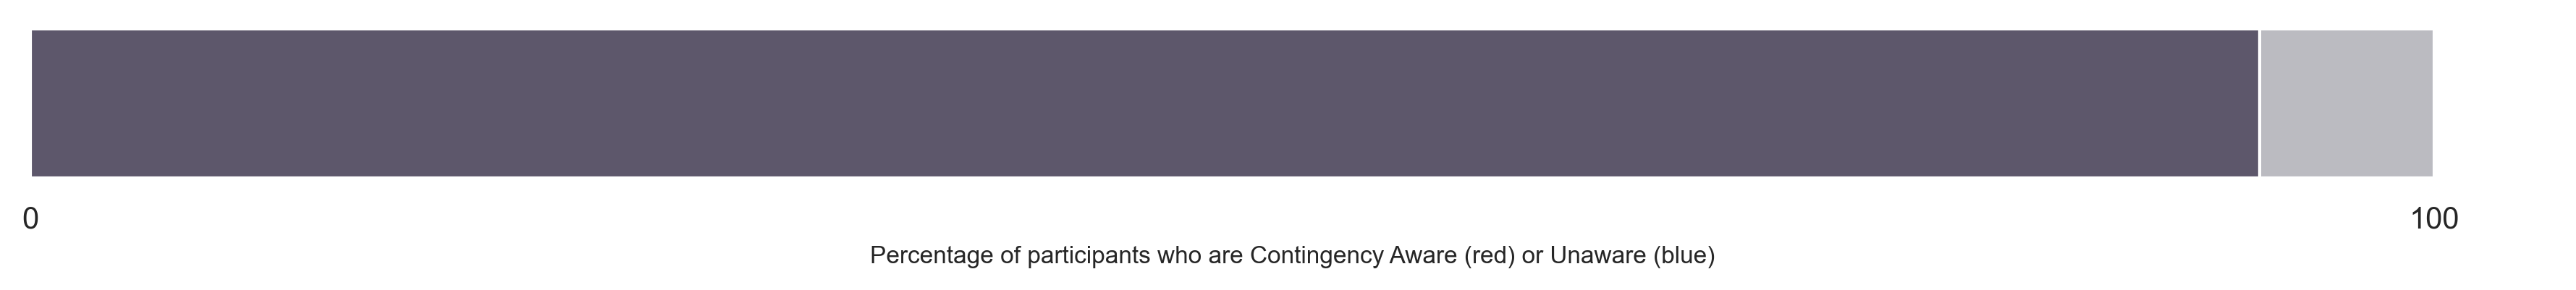

In [7]:
#Plot of contingency awareness in sample
counts = np.bincount(y.astype(int))

# Calculate percentages
percentages = counts / len(y) * 100
print(percentages)
# Set up the font path
fpath = Path("/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

# Set up the figure and axis
sns.set_style("white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 1
fig, ax = plt.subplots()
# Plot the stacked bar chart
bars = ax.barh([0], [percentages[1]], color='#5D576B', label='1')
bars += ax.barh([0], [percentages[0]], left=[percentages[1]], color='#bbbbc1', label='0')

# Add data labels on the right side of the bars
#for bar, percentage in zip(bars, percentages):
#    width = bar.get_width()
#    ax.annotate(f'{percentage:.2f}%', 
#                xy=(width, bar.get_y() + bar.get_height() / 2),
#                xytext=(-50, 0),  # 1 points horizontal offset
#                textcoords="offset points",
#                ha='left', va='center')

# Add labels and title
plt.yticks(font = fpath)
plt.xticks(font = fpath)
ax.set_xticks([0,100])
ax.set_yticklabels([' '])
ax.set_xlabel('Percentage of participants who are Contingency Aware (red) or Unaware (blue)', font = fpath, size = 8)
sns.despine(top=True, left=True, bottom=True, right = True)

# Show the plot
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/CA_PercStackedBar.png', dpi=300)
